<a href="https://colab.research.google.com/github/YuzhouLin/current_proj/blob/feature-20210203-devtest/plot_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

In [137]:
def get_acc(model, sb):
    
    day_n_list = []
    time_n_list = []
    trial_n_list = []
    acc_list = []
    
    for day_n in range(1,6):
        for t_n in range(1,3):
            for T_n in range(1,13):
                tmp_R = pd.read_csv(os.getcwd()+f"/results/{model}/sb{sb}d{day_n}_t{t_n}_T{T_n}.csv")
                day_n_list.append(day_n)
                time_n_list.append('AM') if t_n == 1 else time_n_list.append('PM')
                #time_n_list.append(t_n)
                trial_n_list.append(T_n)
                acc_list.append(np.sum(tmp_R['actual'] == tmp_R['predict'])/len(tmp_R['predict']))
    
    n = len(acc_list)
    acc_dict={
            'model': [model]*n,
            'sb': [sb]*n,
            'day': day_n_list,
            'time': time_n_list,
            'trial': trial_n_list,
            'acc': acc_list
    }
    
    #df_new = pd.DataFrame(acc_dict, index=np.arange(0,n,1))
    df = pd.DataFrame(acc_dict)
    return df

filename = './results/acc_report.csv'
models = ['ecnn0', 'ecnn1', 'ecnn2', 'ecnn3', 'etcn0', 'etcn1', 'etcn2', 'etcn3']

for i in models:
    df_new = get_acc(model=i, sb=1)
    if os.path.exists(filename):
        print('Update new')
        df = pd.read_csv(filename)
        df = df.append(df_new, ignore_index=True)
    else:
        print('Create new')
        df = df_new
    df.to_csv(filename, index=False)
    
df_acc = pd.read_csv('./results/acc_report.csv')

Create new
Update new
Update new
Update new
Update new
Update new
Update new
Update new


In [170]:
df_acc_summary = df_acc.groupby(by=['day', 'time','model']).mean().unstack()





In [171]:
df_acc_summary['acc']

model        ecnn0     ecnn1     ecnn2     ecnn3     etcn0     etcn1  \
day time                                                               
1   AM    0.958443  0.890310  0.351400  0.908545  0.745499  0.800101   
    PM    0.948813  0.882244  0.383882  0.916399  0.766775  0.768466   
2   AM    0.706340  0.693928  0.308599  0.644245  0.568497  0.586091   
    PM    0.670938  0.638595  0.305733  0.653233  0.525128  0.561563   
3   AM    0.665959  0.665229  0.287817  0.627195  0.479417  0.542067   
    PM    0.508997  0.524779  0.272560  0.554999  0.378641  0.382490   
4   AM    0.685479  0.661194  0.262454  0.665216  0.489090  0.549948   
    PM    0.694072  0.701726  0.327572  0.639683  0.548248  0.556397   
5   AM    0.611144  0.602259  0.244319  0.567096  0.414860  0.492949   
    PM    0.647297  0.635560  0.284715  0.586276  0.493005  0.532514   

model        etcn2     etcn3  
day time                      
1   AM    0.581676  0.731484  
    PM    0.560864  0.721695  
2   AM    0.544851  0.561455  
    PM    0.522125  0.543856  
3   AM    0.526568  0.508833  
    PM    0.395564  0.385420  
4   AM    0.530517  0.515950  
    PM    0.550331  0.544563  
5   AM    0.479229  0.453308  
    PM    0.509409  0.507045

<AxesSubplot:xlabel='day,time', ylabel='acc'>

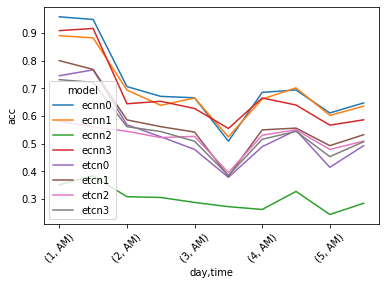

In [172]:
df_acc_summary['acc'].plot(kind='line', rot=45, ylabel='acc')

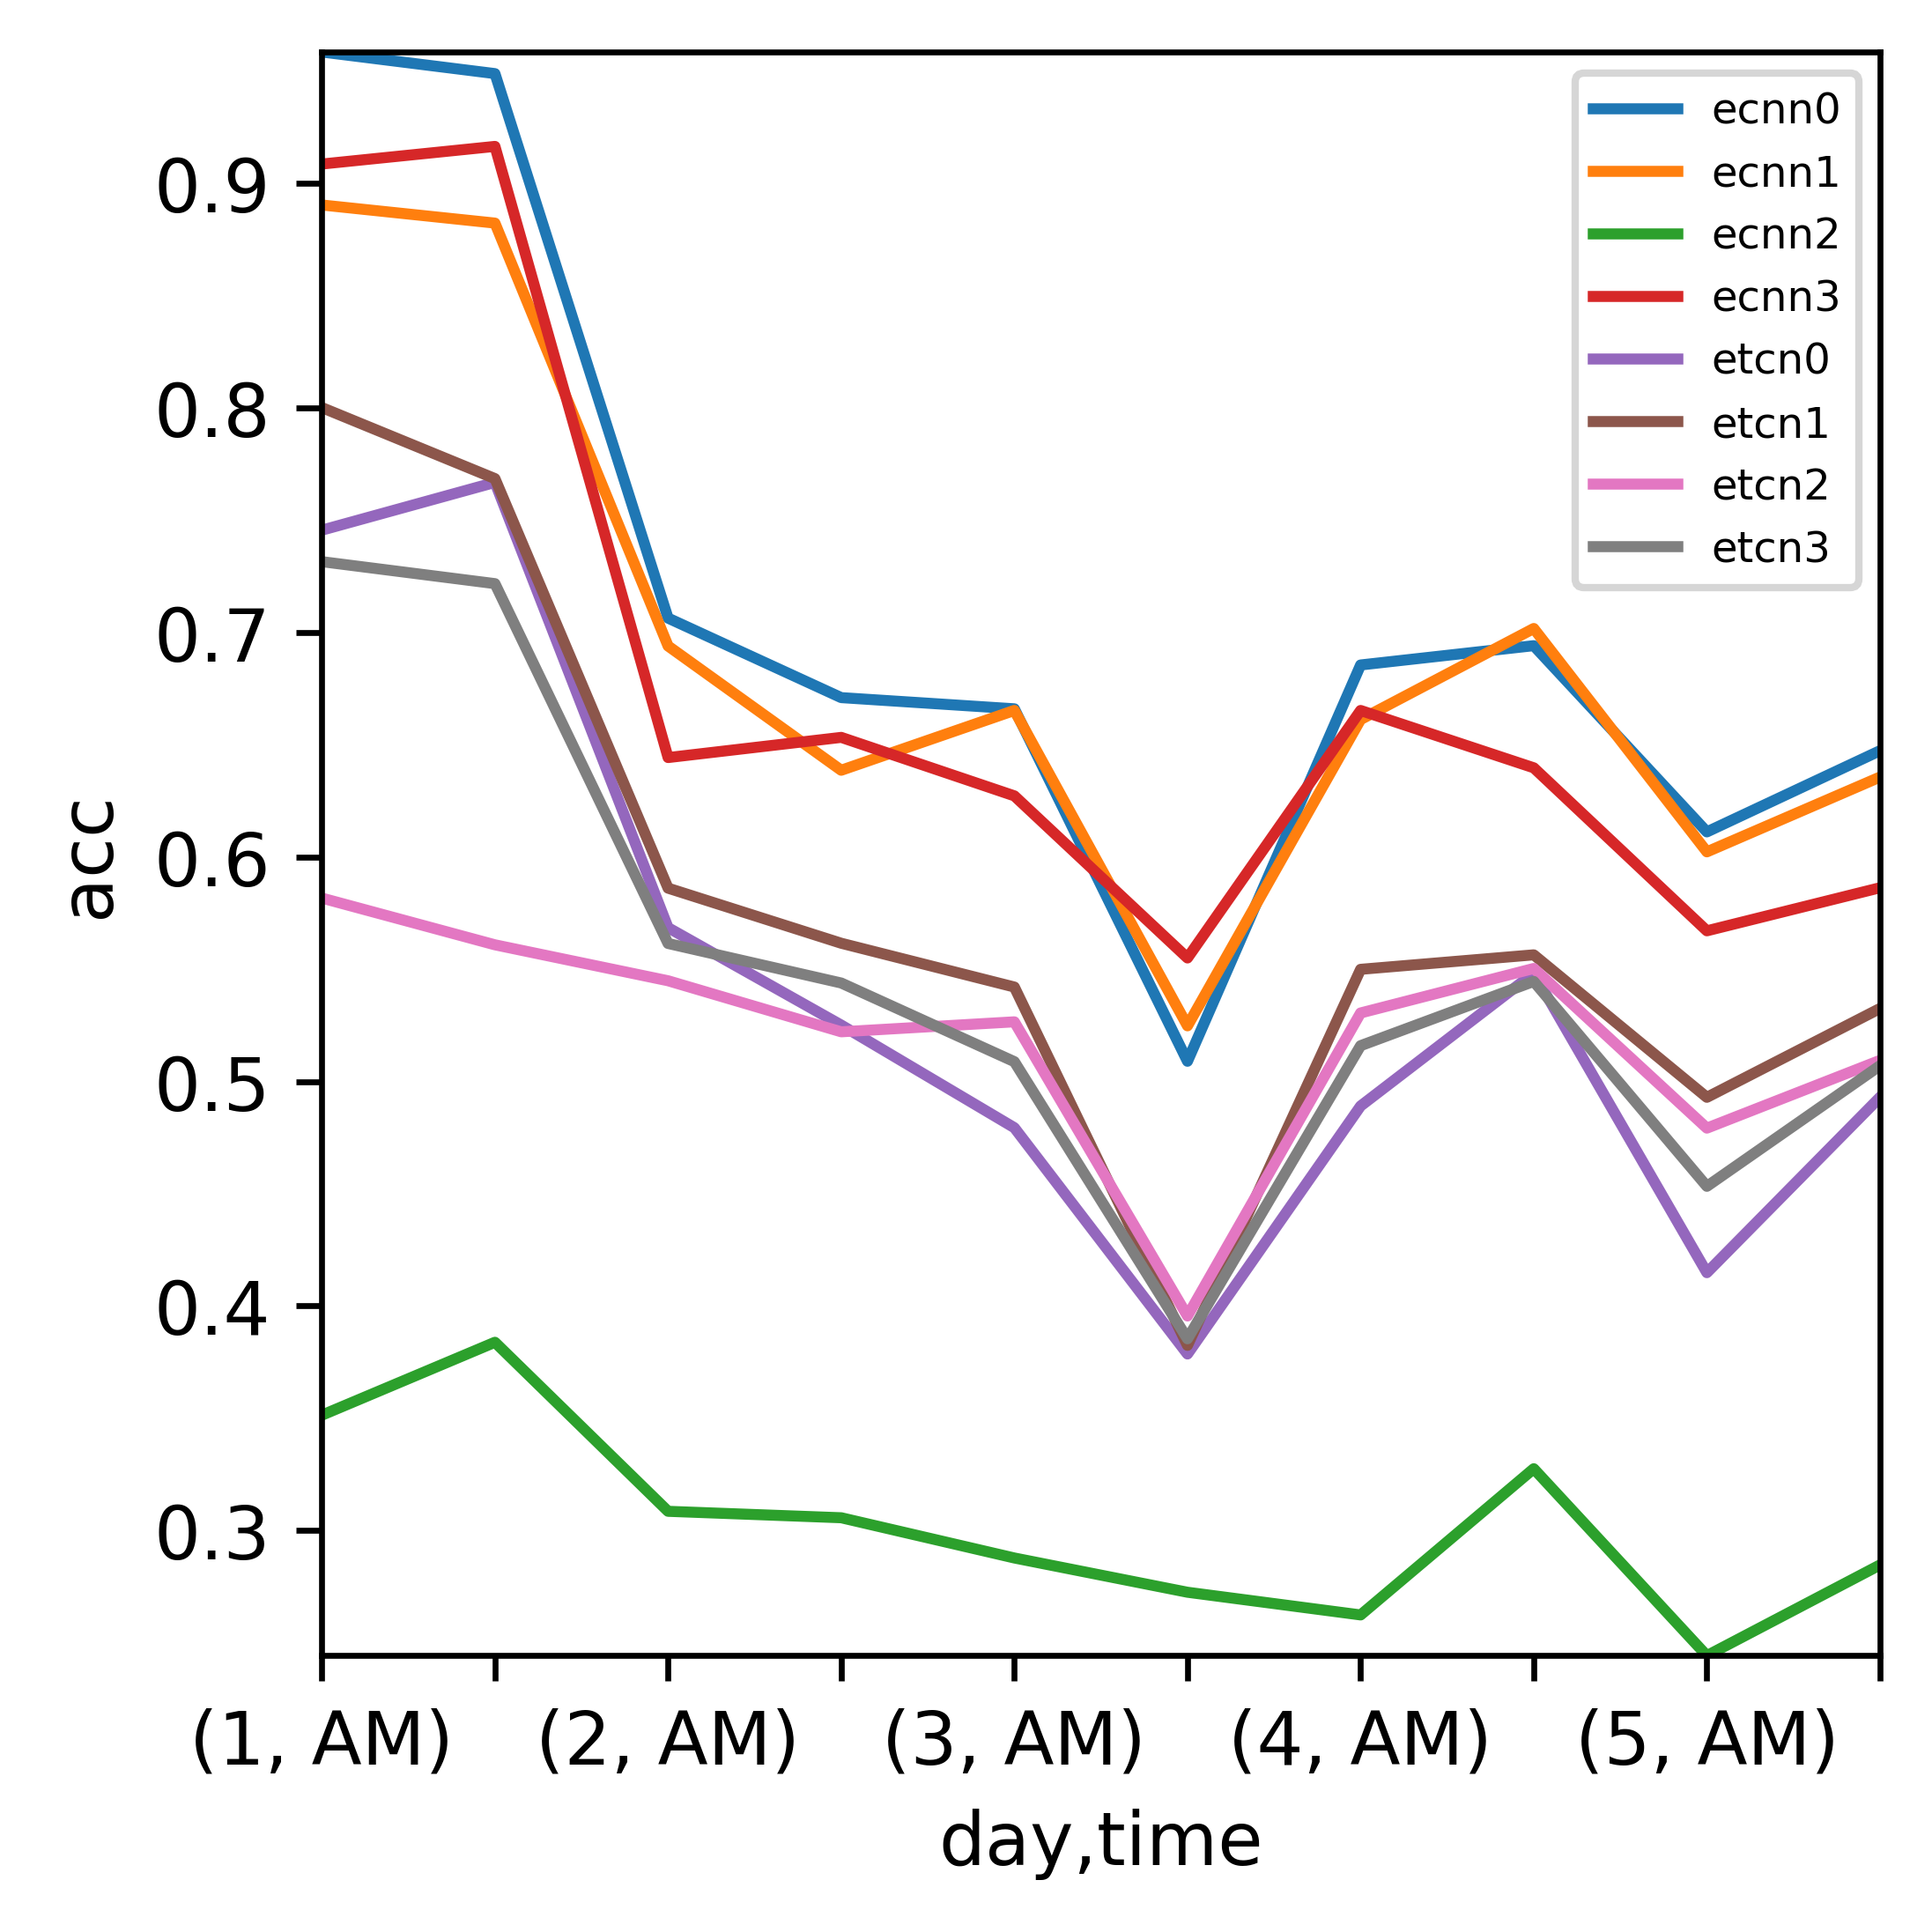

In [176]:
from matplotlib.ticker import MaxNLocator
fig, ax = plt.subplots(1,1, figsize = (7.08/2, 7.08/2), constrained_layout=True,dpi=600)
#df_acc.groupby(['day','model']).mean().unstack().plot(kind='line', y='acc', ax=ax, rot=45, xticks=[1,2,3,4,5], ylabel='acc')
df_acc_summary['acc'].plot(kind='line', ylabel='acc', ax=ax)
ax.xaxis.set_major_locator(MaxNLocator(10))
ax.autoscale(tight=True)
#ax.xaxis.set_ticks([(1,2,3,4,5), ('AM','PM')])  
ax.legend(loc='best', fontsize='xx-small')
plt.savefig("./results/line-acc.png", format='png', bbox_inches='tight', dpi=600, pad_inches=0.0)

'\ni=0\nfor ax in axes.ravel():\n    #sns.heatmap(CM[i], ax = ax, cmap=\'GnBu\')\n    sns.\n    colorbar = True if i==1 or i==3 else False\n    sns.heatmap(CM_model_ave[i], ax = ax, annot=True, cmap=\'Blues\', vmax=1, vmin=0, fmt=\'.2%\', annot_kws={\'size\': 4}, cbar=colorbar)\n    i+=1\n\n\nlabels = [\'CNN\',\'ECNN-A\',\'ECNN-B\',\'ECNN-C\']\nfor ax, label in zip(axes.ravel(), labels):\n    ax.set_title(label,loc=\'center\', fontdict={\'fontsize\': 8})\n    ax.set_xlabel(\'Predicted Finger Movement\', fontdict={\'fontsize\': 8})\n    ax.set_ylabel(\'Acutal Finger Movement\', fontdict={\'fontsize\': 8})\n\nplt.savefig("./results/confusion_matrix_macroave.eps", format=\'eps\', bbox_inches=\'tight\', dpi=600, pad_inches=0.0)\nplt.savefig("./results/confusion_matrix_macroave.png", format=\'png\', bbox_inches=\'tight\', dpi=600, pad_inches=0.0)\n'

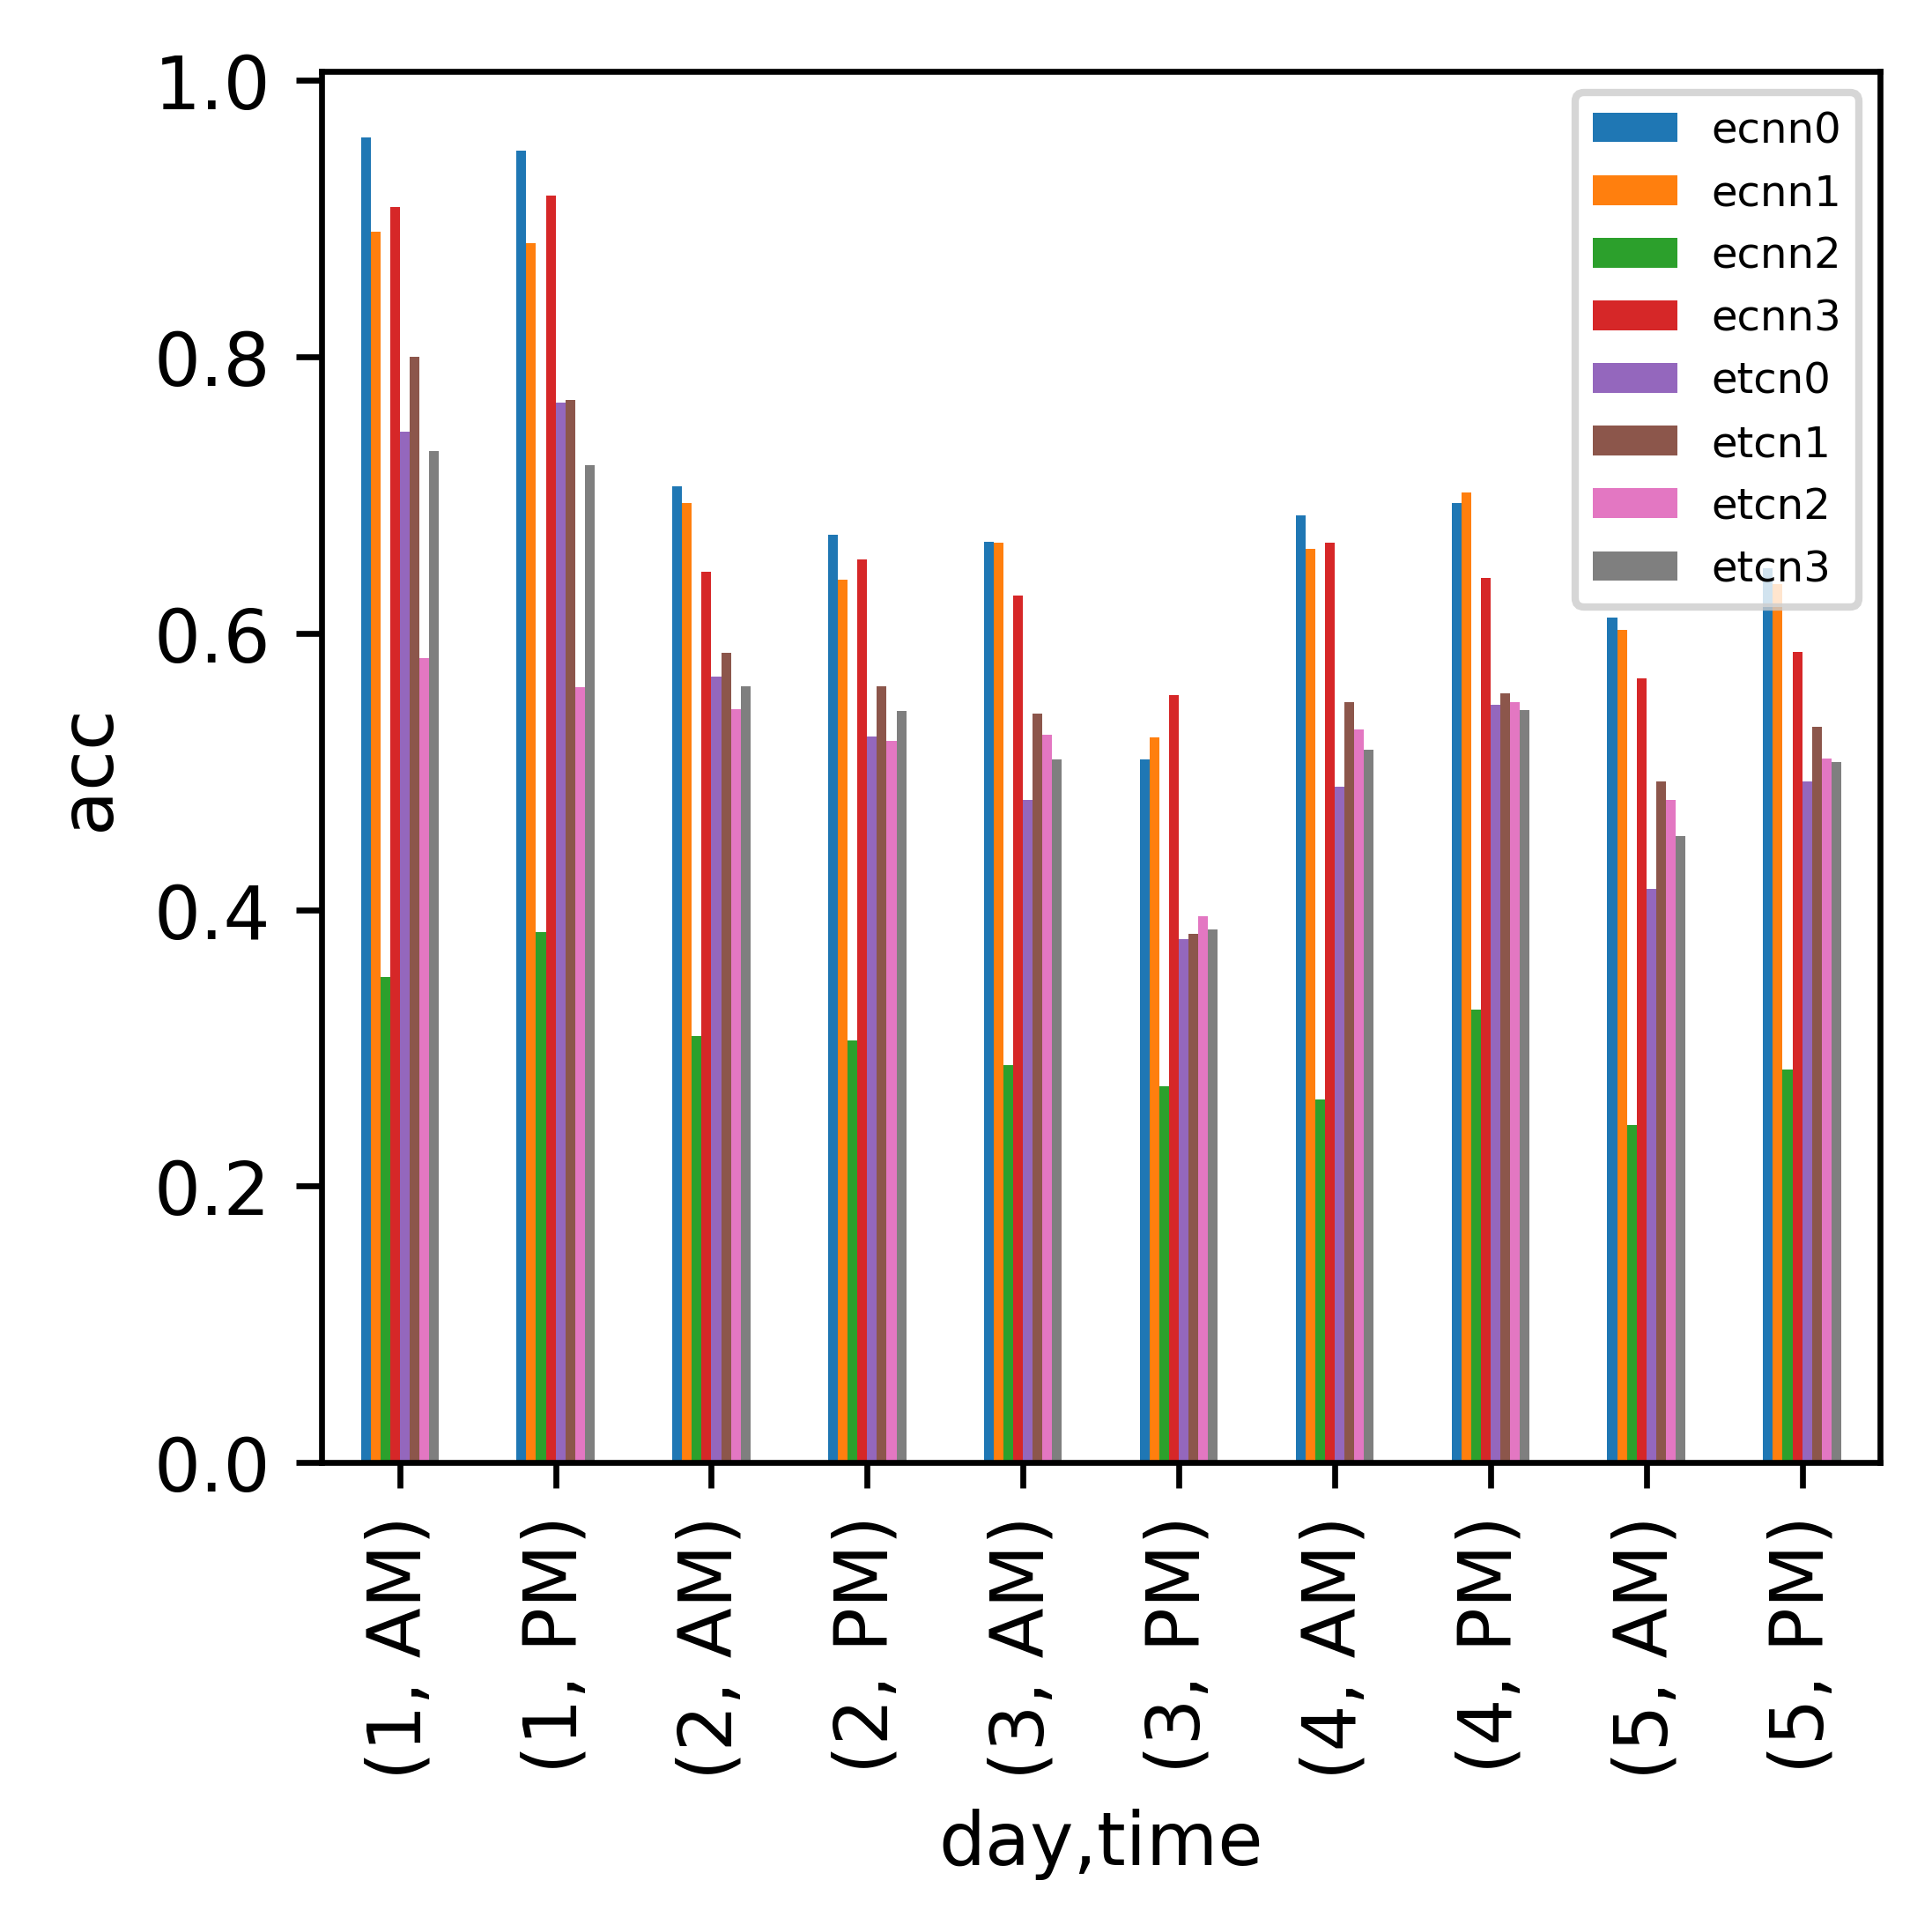

In [178]:

fig, ax = plt.subplots(1,1, figsize = (7.08/2, 7.08/2), constrained_layout=True,dpi=600)
df_acc_summary['acc'].plot(kind='bar', ax=ax, ylabel='acc')
ax.legend(loc='best', fontsize='xx-small')
#plt.savefig("./results/bar-acc.png", format='png', bbox_inches='tight', dpi=600, pad_inches=0.0)
plt.savefig("./results/bar-acc.png", format='png', bbox_inches='tight', dpi=600)
#f, axes = plt.subplots(1,1, figsize = (7.08/2, 7.08/2), constrained_layout=True,dpi=600)

#df_acc.groupby('model').boxplot(x='day',y='acc')

#df_acc.loc[df_acc['model']=='ecnn0'].boxplot(column = ['acc'], by=['day', 'time'], rot=45)

#df_acc.loc[df_acc['model']=='ecnn0'].boxplot(column = ['acc'], by=['day', 'time'], rot=45)
#for ax in axes.ravel():
#    ax = df_acc.plot.bar(x='day', y='acc')

'''
i=0
for ax in axes.ravel():
    #sns.heatmap(CM[i], ax = ax, cmap='GnBu')
    sns.
    colorbar = True if i==1 or i==3 else False
    sns.heatmap(CM_model_ave[i], ax = ax, annot=True, cmap='Blues', vmax=1, vmin=0, fmt='.2%', annot_kws={'size': 4}, cbar=colorbar)
    i+=1


labels = ['CNN','ECNN-A','ECNN-B','ECNN-C']
for ax, label in zip(axes.ravel(), labels):
    ax.set_title(label,loc='center', fontdict={'fontsize': 8})
    ax.set_xlabel('Predicted Finger Movement', fontdict={'fontsize': 8})
    ax.set_ylabel('Acutal Finger Movement', fontdict={'fontsize': 8})

plt.savefig("./results/confusion_matrix_macroave.eps", format='eps', bbox_inches='tight', dpi=600, pad_inches=0.0)
plt.savefig("./results/confusion_matrix_macroave.png", format='png', bbox_inches='tight', dpi=600, pad_inches=0.0)
'''

In [17]:
os.getcwd()

'c:\\Users\\57600\\github\\TCN-proj'